In [2]:
import numpy as np
import pandas as pd
import datetime
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import random
warnings.filterwarnings("ignore")

In [ ]:
#the Dataframe
df = pd.read_excel("Model_Dataset.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sales              79 non-null     float64
 1   Year               79 non-null     int64  
 2   Month              79 non-null     object 
 3   GrossMargin Value  79 non-null     float64
 4   COGSold            79 non-null     float64
 5   COGReceived        79 non-null     float64
 6   Inventory Value    79 non-null     float64
 7   Placed Orders      79 non-null     float64
 8   Open Orders        79 non-null     float64
 9   Returns            79 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 6.3+ KB


In [4]:
#Clean df and convert month data to integer and then cycle patterned data. 
df['Month'] = pd.to_datetime(df['Month'], format='%b').dt.month
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)
df = df.drop(columns='Month')

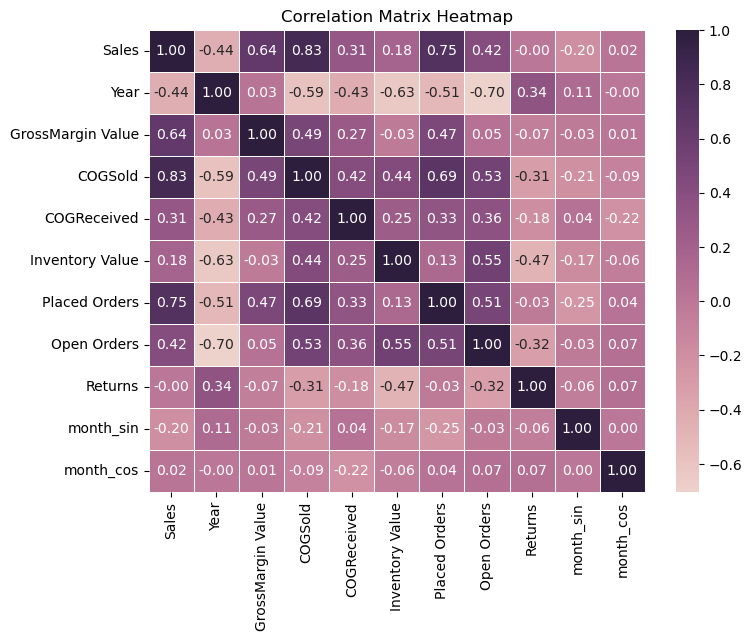

In [5]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
rocket_cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=rocket_cmap, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [6]:
X = df.drop(['Sales'],axis=1)
y = df['Sales']
#split target variable and scale
split_year = 2025
train_df = df[df['Year'] < split_year]
test_df = df[df['Year'] >= split_year]

X_train = train_df.drop(['Sales'], axis=1)
# Training target
y_train = train_df['Sales']

# Testing features (all columns except 'Sales')
X_test = test_df.drop(['Sales'], axis=1)
# Testing target
y_test = test_df['Sales']

#Scale dataframe
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(low=100, high=175),
    'max_depth': randint(low=12, high=15),
    'min_samples_split': randint(low=6, high=15),
    'max_features': uniform(loc=0.2, scale=0.3),
    'min_samples_leaf' : randint(low=6, high=8)
}

# Initialize and run RandomizedSearchCV
rfregressor = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rfregressor,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    # Specify multiple scoring metrics
    scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'},
    refit='R2', # Refit the final model based on R2 score
    return_train_score=True, # Ensure train scores are included
    n_jobs=-1,
    random_state=42,
)
random_search.fit(X_train, y_train)

# Create a DataFrame from the results
results_df = pd.DataFrame(random_search.cv_results_)

# Extract relevant columns
# 'params' contains the dictionary of hyperparameters
# 'mean_test_R2' contains the average R-squared score across CV folds
hyperparameter_results = results_df[[
    'params', 
    'mean_test_R2', 
    'r2_score'
    'std_test_R2', # Standard deviation of R2 scores across folds
    'mean_train_R2',
    'rank_test_R2' # Rank of each combination based on R2
]].sort_values(by='mean_test_R2', ascending=False).reset_index(drop=True)

# Evaluate the final best model on the **held-out test data**
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance on Held-Out Test Data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# The best_score_ attribute now corresponds to the 'R2' metric because of `refit='R2'`
print(f"Best cross-validation R2: {random_search.best_score_:.2f}")


Final Model Performance on Held-Out Test Data:
Mean Squared Error: 82091203487.63
Root Mean Squared Error: 286515.63
R-squared Score: 0.14
Best cross-validation R2: 0.29


In [22]:
hyperparameter_results

,params,mean_test_R2,std_test_R2,mean_train_R2,rank_test_R2
0,"{'max_depth': 12, 'max_features': 0.4854649923...",0.290437,0.359812,0.654077,1
1,"{'max_depth': 13, 'max_features': 0.4482613686...",0.287775,0.360595,0.654442,2
2,"{'max_depth': 12, 'max_features': 0.4329790558...",0.287549,0.359275,0.657626,3
3,"{'max_depth': 14, 'max_features': 0.4409419269...",0.287347,0.360215,0.657103,4
4,"{'max_depth': 14, 'max_features': 0.4419683443...",0.287347,0.360215,0.657103,4
...,...,...,...,...,...
495,"{'max_depth': 12, 'max_features': 0.2814628747...",0.119358,0.323860,0.558405,496
496,"{'max_depth': 12, 'max_features': 0.2769688351...",0.119358,0.323860,0.558405,496
497,"{'max_depth': 14, 'max_features': 0.2130984973...",0.113321,0.323159,0.558212,498
498,"{'max_depth': 12, 'max_features': 0.2034060934...",0.106813,0.323114,0.556151,499


In [72]:
#Best Model 
rfregressor = RandomForestRegressor(max_depth=12, max_features=0.40685802530946835,min_samples_leaf=2,min_samples_split=2,n_estimators=118, random_state=42)
rfregressor.fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 90216338244.40
Root Mean Squared Error: 300360.35
R-squared Score: 0.06


In [74]:
y_pred = np.round(y_pred, decimals=2)
pred_test_df = pd.DataFrame(y_pred, columns = ['Prediction'])
test_df_ = pd.DataFrame(y_test).reset_index(drop=True)
pred_test_df = pd.concat([pred_test_df,test_df_],axis=1)
index = pd.DataFrame(['jan','feb','mar','apr','may','jun','jul'])
pred_test_df = pd.concat([pred_test_df,index],axis=1).set_index(0)
pred_test_df['Difference'] = pred_test_df['Prediction']-pred_test_df['Sales']
pred_test_df

,Prediction,Sales,Difference
0,,,
jan,1142511.62,1689630.57,-547118.95
feb,1052821.86,875660.25,177161.61
mar,1699202.95,1668320.56,30882.39
apr,1505197.86,1250591.02,254606.84
may,1193261.03,1486397.37,-293136.34
jun,1533671.39,1665250.34,-131578.95
jul,2217510.03,1854510.46,362999.57
